# N.B.
- [ ] Create a class to save data into a file
- [ ] Check pauses into the codes and remove redundant ones (or add them if necessary).
- [ ] With sGen.pul_trig_mode(**'AUTO'**) there aren't errors, instead with sGen.pul_trig_mode(**'SING'**) (theorically more correct) the code stops working.  
    *-1074118634: The trigger has not occurred for the requested buffer, so data cannot be fetched relative to the trigger.*
- [ ] controllare se ad alte frequenze se le oscillazioni si vedono anche sull'oscilloscopio
- [ ] CHIEDERE RIGUARDO AI BATTIMENTI (ES SWEEP 39)



s

In [1]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *

# Setup parameters

In [3]:
ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

# parameters for the Signal Generator
f_min           = 8.5718125e9 - 20e6                                 # tryout value
f_max           = 8.5718125e9 + 20e6                                 # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e9)          # Set range of frequency of the signal to send to the resonator
amplitude       = -10                           # Set the amplitude of the signal in dBm
sample_rate     = 250e6 # Maximum Value: 250.0e6
pulse_width     = 5                                 # 2 microsec
pulse_delay     = 0
pulse_period    = 10  


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate # Maximum Value: 250.0e6

pxie.open(port = 1)


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

SMA100B: Connection successful!
5170R: Available communication!


In [15]:
# import niscope as ni
# with ni.Session("PXI1Slot3") as session:
#     session.reset()

# Acquisition of signals for each frequency in the range

In [4]:
fetched_data = []
sGen.RF_lvl_ampl(-10)
pulse_freq = np.array([100e6])

for i in pulse_freq:
#     #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
    sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.1)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
    sGen.pul_state(0)
    sGen.RF_state(0)
    data = wfm[0].samples.tolist()
    fetched_data += [{'freq': i, 'data': data}]

print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))


AcquisitionStatus.COMPLETE
Number of sweeps: 1 / 1


In [4]:
# fetched_data = []
# pota = np.arange(, , )
# for pot in pota:
#     sGen.RF_lvl_ampl(pot)
#     for i in pulse_freq:
#     #     #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
        
#         sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
#         sGen.pul_state(1)
#         sGen.RF_state(1)
#         time.sleep(0.1)
#         wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
#         sGen.pul_state(0)
#         sGen.RF_state(0)
#         fetched_data += [{'freq': i,'power': pot 'data': wfm[0].samples.tolist()}]

# # print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))

SyntaxError: invalid syntax (3146229806.py, line 2)

# Plot of a sweep with the peaks of amplitudes marked

In [6]:
def data_amps(y: np.array, toggle_plot = True):
    x = np.arange(len(y))/sample_rate
    std = np.std(y)
    indices = find_peaks(y, prominence=2*(np.max(y) - std))
    idx = indices[0]
    offset = 5
    idx = idx[offset:-offset]
    
    if toggle_plot:
        # plt.clf()
        plt.grid()
        plt.plot(x, y)
        plt.scatter(x[idx],y[idx], color = 'orange')
        plt.draw()
    # return {'mean': np.mean(y[idx]), 'std' : np.std(y[idx])}
    return (x, idx)

# Save data on HDF5 file

In [ ]:
# with h5py.File('nonloso_2.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
#     for j in range(0, len(fetched_data)):
#         gp_data = f.create_group(str(j))
#         freq, data = fetched_data[j].items()
#         gp_data.create_dataset(str(freq[0]), data = freq[1])
#         gp_data.create_dataset(str(data[0]), data = data[1])

# Read data from HDF5 file

In [5]:
fetched_data = []
with h5py.File('nonloso_2.hdf5', 'r') as f:
    
    for j in range(len(f)):
        dic = {}
        gp = f[str(j)]
        for i, k in gp.items():
            dic[i] = k[()]
        fetched_data += [dic]


# First Data Analysis tryout

In [ ]:
# offset = 2.5e-6
# end = 5e-6

# with h5py.File('nonloso.hdf5', 'r'):
    

In [ ]:
# amps = []
# with h5py.File('nonloso_2.hdf5', 'r') as f:
#     for j in range(1,len(f)):
#         gp = f[str(j)]
#         dic = {}
#         for i, k in gp.items():
#             dic[i] = k[()]
#         freq = dic['freq']
#         data = dic['data']

            
#         amps = amps + [data_amps(data, False)['mean']]


# plt.clf()
# plt.plot(amps)
# plt.show()

15

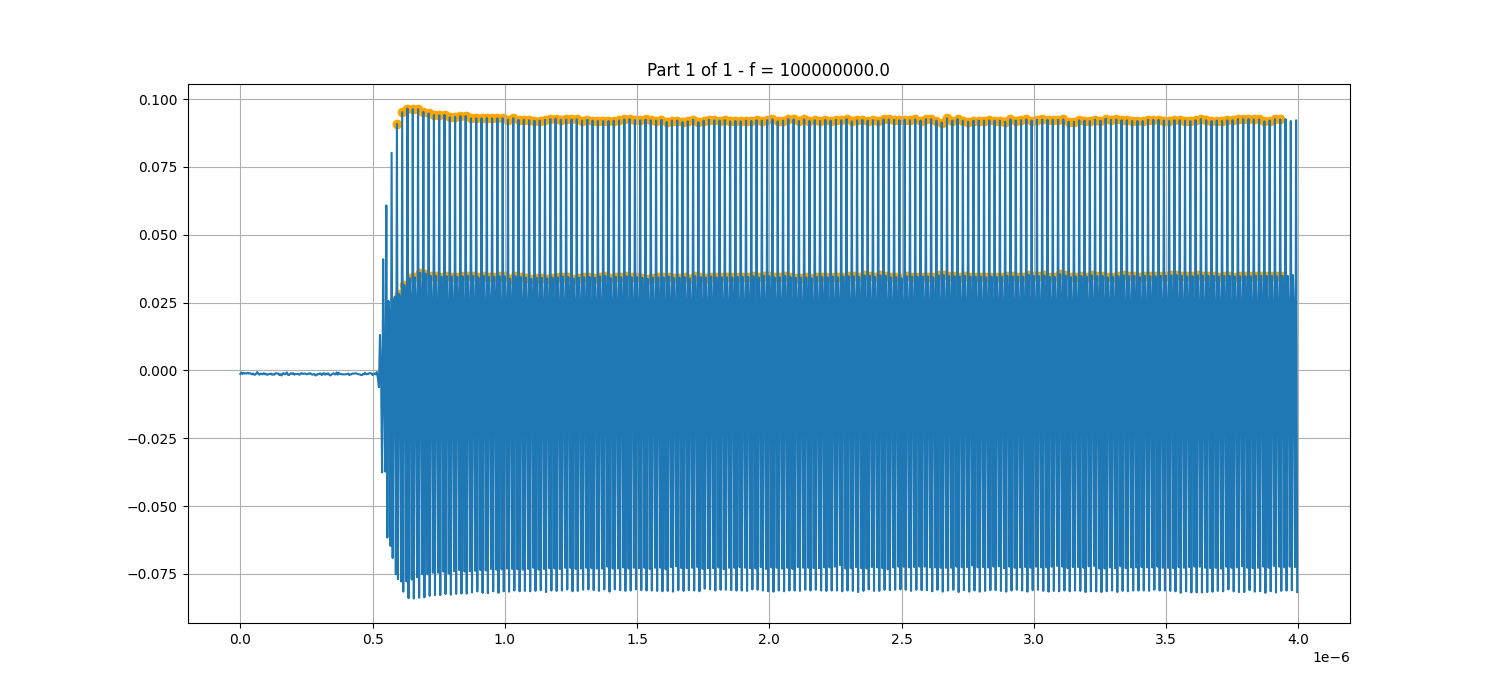

In [8]:
sample_rate        = 250e6 # Maximum Value: 250.0e6

sweep = 0
f_chosen = fetched_data[sweep]
f = f_chosen['freq']
y = np.array(f_chosen['data'])
fig = plt.subplots(figsize = (15,7))[0]
plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
x, idx = data_amps(y, toggle_plot = True)

def on_key(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data):
        sweep = 0
    elif sweep == -1:
        sweep = len(fetched_data)-1

    f_chosen = fetched_data[sweep]
    y = np.array(f_chosen['data'])
    x, idx = data_amps(y, toggle_plot = False)

    # clear frame
    plt.clf()
    plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
    plt.grid()
    plt.plot(x, y)
    # plt.scatter(x[idx],y[idx], color = 'orange')
    plt.draw() # redraw

fig.canvas.mpl_connect('key_press_event',on_key)

Stare attenti a IQ mixer, se mandiamo troppa potenza serve un attenutore prima del mixer

# Demodulation with FT

In [27]:
def weight_factor (ft, range_mask):
    # tot_int = np.trapz(ft)
    tot_int = np.sum(ft)
    ft[~range_mask] = 0
    # portion = np.trapz(ft)
    portion = np.sum(ft)

    return tot_int/portion



In [28]:
def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
    N = len(y)
    T = 1/sample_rate
    FT = np.fft.fft(y)
    PHI = np.unwrap(np.angle(FT))


    freqs = np.fft.fftfreq(N,T) 
    offset = 5e6
    mask = (freqs < (freq+offset)) & (freqs > (freq-offset))
    maxx = np.max(FT[mask])
    phi = PHI[np.where(FT == maxx)]



    range = .3e8
    FT = np.fft.fft(y * np.cos(x*freq*2*np.pi + phi))
    # print(FT)
    freqs = np.fft.fftfreq(N,T)  
    region_mask = (freqs >= -range) & (freqs <= range)
    x_region = FT.copy()
    x_region[~region_mask] = 0

    # IFT = np.fft.ifft(x_region*2)
    w_f = weight_factor (np.abs(FT), region_mask)
    print(w_f)
    IFT = np.fft.ifft(x_region*w_f)
    IFT_2 = np.fft.ifft(x_region*2)
    # average = np.average(np.abs(IFT[300:500]))


    AB_IFT = np.abs(IFT)
    AB_IFT_2 = np.abs(IFT_2)
    indices = find_peaks(AB_IFT, height= np.average(AB_IFT))
    idx = indices[0]
    offset = 10
    idx = idx[offset:-offset]
    average = np.average(AB_IFT[idx])
    print(len(AB_IFT))

    if toggle_plot:
        # plt.clf()
        
        # plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {freq} average = {average}')
        plt.plot(freqs,np.abs(FT))
        plt.subplot(1,2,2)
        plt.plot(np.arange(len(y))*T, AB_IFT_2, linewidth = 3, color = 'red')
        # plt.plot(AB_IFT_2)
        # plt.scatter(np.arange(len(AB_IFT))[idx]*T,AB_IFT[idx], color = 'orange')
        plt.draw()

In [1]:
sweep = 0
f_chosen = fetched_data[sweep]
f       = f_chosen['freq']
data    = f_chosen['data']

fig2 = plt.subplots(figsize = (15,7))[0]

y = np.array(data)
x = np.arange(len(y))/sample_rate

plt.clf()
print(len(y))

data_fft(y, f, sample_rate, True)


def on_key_fft(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data):
        sweep = 0
    elif sweep == -1:
        sweep = len(fetched_data)-1

    f_chosen = fetched_data[sweep]
    f       = f_chosen['freq']
    data    = f_chosen['data']
    y = np.array(data)
    
    plt.clf()
    data_fft(y, f, sample_rate, True) 
    

    # # clear frame
    # plt.clf()
    # plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
    # plt.grid()
    # plt.plot(x, y)
    # plt.draw() # redraw

fig2.canvas.mpl_connect('key_press_event',on_key_fft)

NameError: name 'fetched_data' is not defined

1000
2.1635698337949405
1000


15

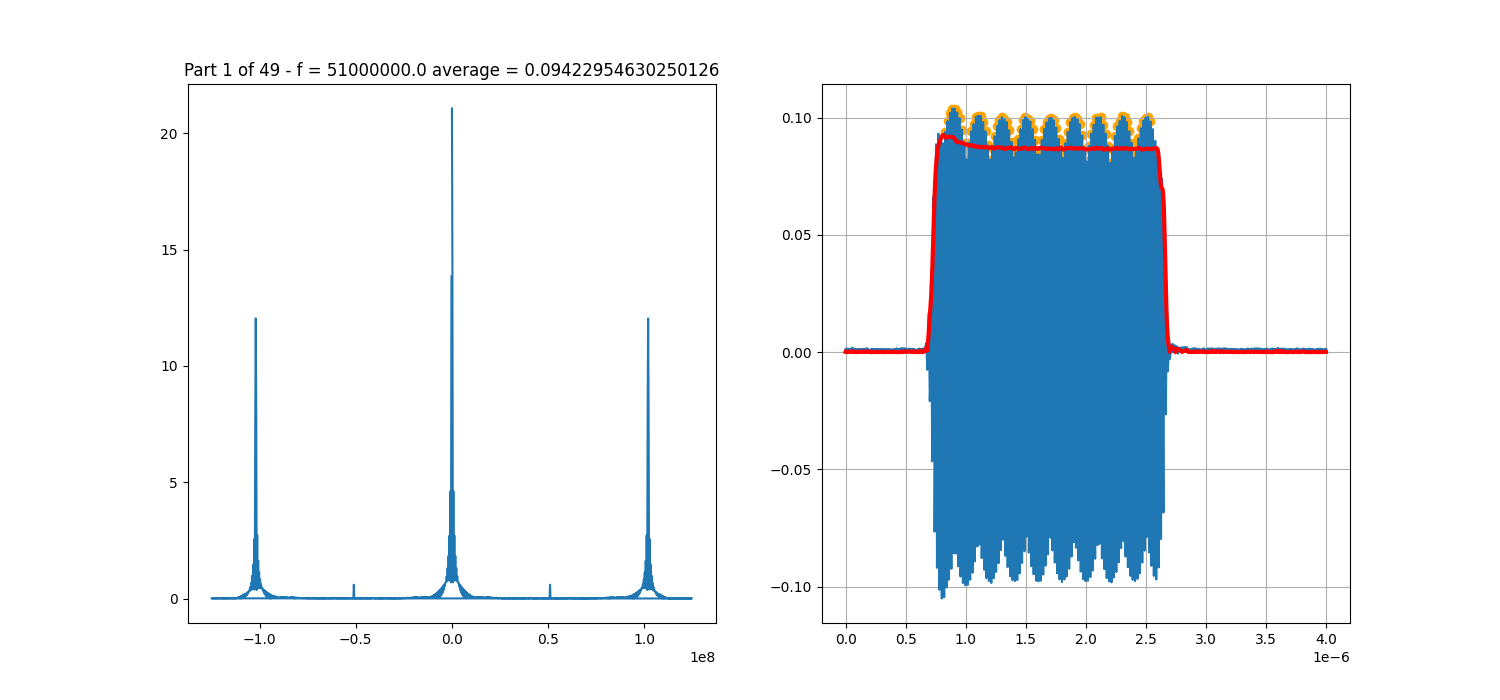

2.1691771068350767
1000
2.3185032871485993
1000
2.3479026445818207
1000
2.3375176381663723
1000
2.2975490390357924
1000
2.2713673838566164
1000
1.9878121251272165
1000
1.9660135437290602
1000
1.9393559167029235
1000
2.236816118105583
1000
1.7783722417102417
1000
2.1407952829302435
1000
2.1257834659376917
1000
2.182005294997053
1000
2.3225248219999486
1000
1.9705355891395193
1000
1.9845774108285525
1000
1.987633450872928
1000
2.2631559742600316
1000
2.0187913009586214
1000
2.3944805024386926
1000
2.0387848483253648
1000
2.45111000079457
1000
2.31795227591017
1000
2.480565723639921
1000


In [30]:
sweep = 0
f_chosen = fetched_data[sweep]
f       = f_chosen['freq']
data    = f_chosen['data']

fig2 = plt.subplots(figsize = (15,7))[0]

y = np.array(data)
x = np.arange(len(y))/sample_rate

plt.clf()
print(len(y))

plt.subplot(1,2,2)
data_amps(y, toggle_plot = True)
data_fft(y, f, sample_rate, True)


def on_key_fft(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data):
        sweep = 0
    elif sweep == -1:
        sweep = len(fetched_data)-1

    f_chosen = fetched_data[sweep]
    f       = f_chosen['freq']
    data    = f_chosen['data']
    y = np.array(data)
    
    plt.clf()
    
    plt.subplot(1,2,2)
    data_amps(y, toggle_plot = True)
    data_fft(y, f, sample_rate, True) 
    

    # # clear frame
    # plt.clf()
    # plt.title(f'Part {sweep+1} of {len(fetched_data)} - f = {f}')
    # plt.grid()
    # plt.plot(x, y)
    # plt.draw() # redraw

fig2.canvas.mpl_connect('key_press_event',on_key_fft)

- per sistemare il fattore 2, dobbiamo sommare tutto il set FT e dividerlo per il set attorno al picco a f = 0 (integrare tutto e dividere per l'integrale sotto f = 0)
- https://en.wikipedia.org/wiki/Product_detector

# Controllare se il weight factor è corretto, confrontando con media fatta col 2* e con media visiva degli sweep sopra...
